In [97]:
import os
from os.path import join, dirname, pardir
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

#so pandas doesn't spit out a warning everytime
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

# import data

In [72]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [73]:
train.shape

(1460, 81)

In [74]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [75]:
train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

This data set has three types of data types, which map to two different types of variables; integers and floats -> Numberical variables, and objects -> categorical variables.

# data exploration
First let's take a look at the target variable; Sales Price

In [61]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

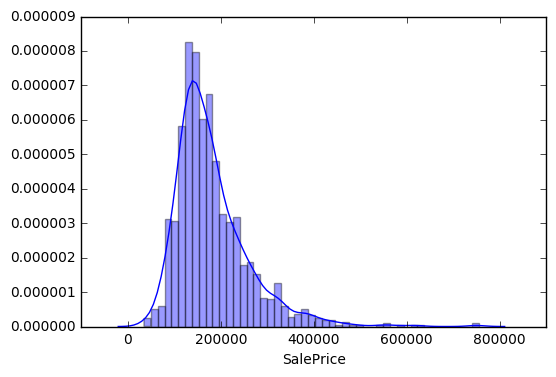

In [66]:
sns.distplot(train.SalePrice)

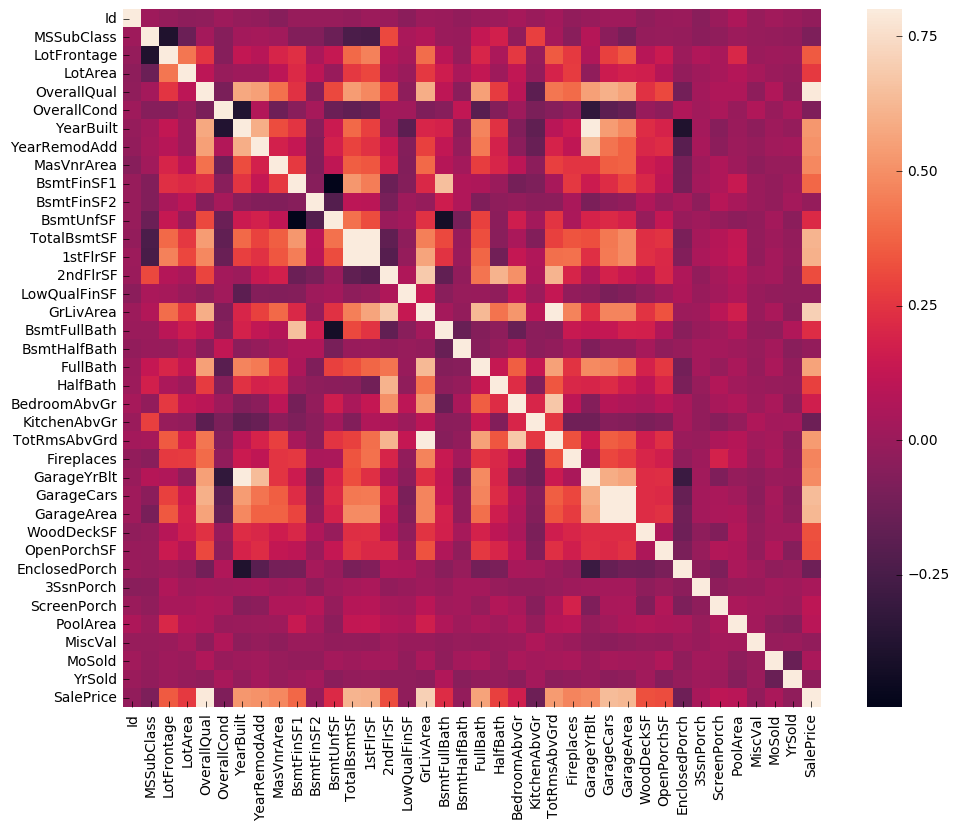

In [67]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

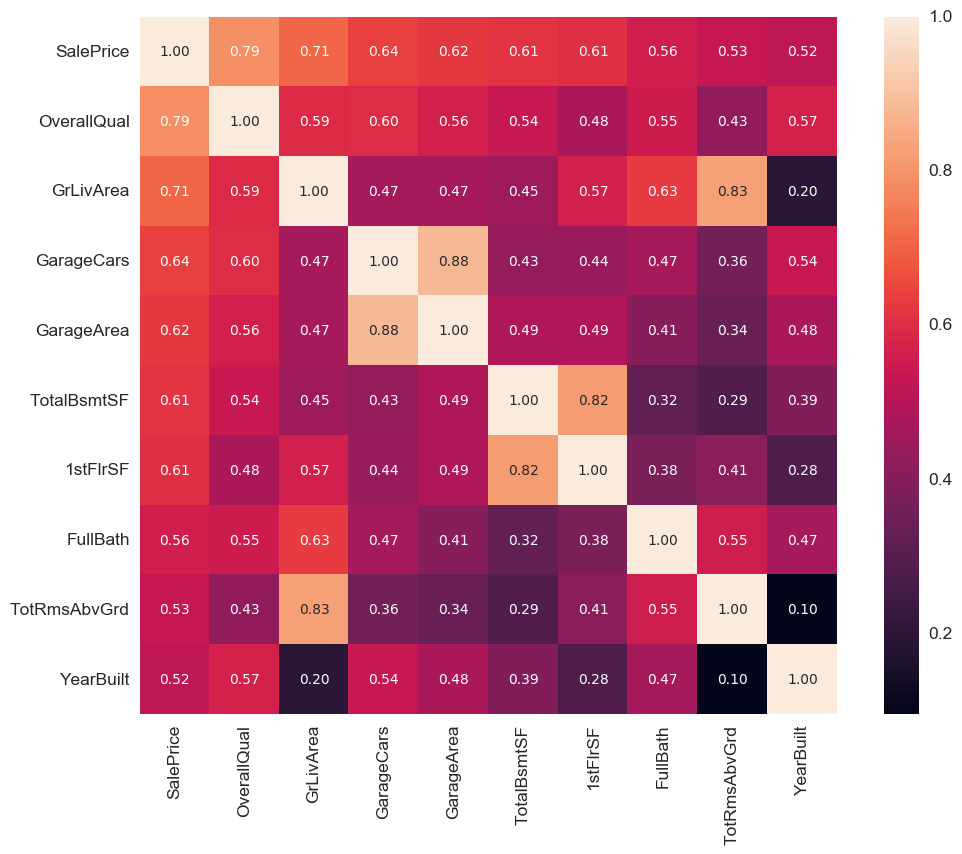

In [71]:
#saleprice correlation matrix
f, ax = plt.subplots(figsize=(12, 9))
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The above are a number of plots taken from: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python . Its a great post so instead of recreating all his work in this notebook, I'm going to use his learnings to process the data.

# Data Processing

In [76]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [78]:
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() 

0

In [81]:
# Outliers
#deleting points
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

In [83]:
#applying log transformation
train['SalePrice'] = np.log(train['SalePrice'])

In [85]:
train['GrLivArea'] = np.log(train['GrLivArea'])

In [90]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1
train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


In [92]:
#convert categorical variable into dummy
train = pd.get_dummies(train)

# data pipeline

In [106]:
my_pipeline = make_pipeline(Imputer(), RandomForestRegressor())

# fit model

In [107]:
my_pipeline.fit(train_X, train_y)
predictions = my_pipeline.predict(test_X)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 20687.7920548


In [108]:
predictions = test.select_dtypes(exclude=['object'])
predicted_prices = my_pipeline.predict(predictions)

# create submission file

In [109]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})
filename = 'RandomForestRegressor_20180829'
my_submission.to_csv('../submissions/{}.csv'.format(filename), index=False)

# push submission to Kaggle

In [40]:
!bash kaggle

bash: kaggle: No such file or directory


In [38]:
!pwd

/Users/andy/personal/housepriceprediction/notebooks
